---
# Example of classification using quadratic discriminant analysis (QDA).
---

In this detailed script, we generate a dataset from a mixture of two gaussian probability distribution functions (PDF). 
Each one is weighted with its <i>a priori</i> class probability $P(C_{i})$:

<blockquote>  $P(\bf{x}) = P(\bf{x}|C_{1}) P(C_{1}) + P(\bf{x}|C_{2}) P(C_{2})$ </blockquote>


Using this "experimental dataset", we use the QDA method to locate the influence zone of each class i over a 
spatial grid. This corresponds to the zone where 

<blockquote> $P(\bf{x}|C_{i}) P(C_{i}) > P(\bf{x}|C_{j}) P(C_{j})$ </blockquote>

The size of the experimental dataset has a large effect on the precision of the classification results. 
This is investigated in another script. We use datasets with 1000 data points.  



In [1]:
print(__doc__)

# Authors: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: XXX

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import stats
from scipy.stats import multivariate_normal

from skimage.transform import resize

import math

import seaborn as sns; sns.set()

Automatically created module for IPython interactive environment


# Part I: Detailed example of a gaussian mixture with classification results
Parameters of the two gaussians PDF:

In [2]:
# For replicability
np.random.seed(42)

# Centers of the PDF
Mu = np.zeros((2,2))
Mu[0,:] = [6., 3.] # PDF 1
Mu[1,:] = [6., 7.] # PDF 2

# Standard deviations along the principal axes (sigma_PCA_1 >= sigma_PCA_2)
sigma = np.zeros((2,2))
sigma[0,:] = [2., 0.7] # PDF 1
sigma[1,:] = [1.2, 0.7] # PDF 2

# Rotation angles from the first principal axis
theta = np.array([-30., 0.]) # PDF 1 and PDF 2

npts = 1000

# A priori class probabilities
prob_C = np.array([0.5, 0.5]) # PDF 1 and PDF 2


Compute the covariance matrix $\Sigma$ for the two gaussian PDF. 
The $\Sigma$ matrix is defined as:

<blockquote>  $\Sigma = \begin{pmatrix} \sigma_{x_{1}}^2 & \sigma_{x_{1,2}} \\ \sigma_{x_{1,2}} & \sigma_{x_{2}}^2 \end{pmatrix}$ </blockquote>

Instead of using trials and errors to guess the values of $\sigma_{x_{1}}$, $\sigma_{x_{2}}$ and $\sigma_{x_{1,2}}$, we use instead the following method. 
We select values of $\sigma_{PCA_{1}}$, $\sigma_{PCA_{2}}$ for an ellipsoid aligned with the x and y axis and an 
angle $\theta$ to rotate the axes. The following code generates the $\Sigma$ matrix.


In [3]:
n_PDF = 2
Sigma = np.zeros((2, 2, n_PDF))
for n in range(n_PDF):
    cov = np.zeros((2, 2))

    # Rotation matrix
    angle = np.radians(theta[n])
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[c, -s], [s, c]])

    # Covariance matrix for a PDF with its principal axes oriented along the x and y directions
    C = np.array([[sigma[n,0]**2, 0.],[0., sigma[n,1]**2]])

    # Covariance matrix after rotation
    Sigma[:,:,n] = R.dot(C.dot(R.T))
    

Generate a spatial grid where the PDF will be evaluated locally.

In [4]:
nx, ny = 300, 300
x_min, x_max = 0., 10.
y_min, y_max = 0., 10.

xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
pos = np.dstack((xx, yy)) 

Compute the global PDF as a sum of weighted PDF

In [5]:
model = multivariate_normal(Mu[0,:], Sigma[:,:,0]) 
pdf0 = prob_C[0]*model.pdf(pos)

model = multivariate_normal(Mu[1,:], Sigma[:,:,1]) 
pdf1 = prob_C[1]*model.pdf(pos)

pdf = pdf0 + pdf1

## Show the weighted PDF
The weighted PDF are defined as:
<blockquote>  $P_{i}(\bf{x}) = P(\bf{x}|C_{i}) P(C_{i}) = \frac{1}{2\pi |\Sigma_{i}|^{0.5}} \exp{[-\frac{1}{2}(\bf{x}-\bf{\mu_{i}})^\top \Sigma_{i}^{-1} (\bf{x}-\bf{\mu_{i}})] P(C_{i})}$  </blockquote>


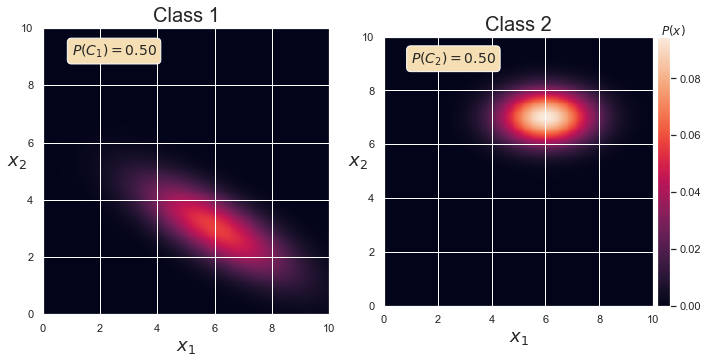

In [6]:
pdf_max = np.max([np.max(pdf0), np.max(pdf1)])

pdf0 = np.flipud(pdf0)
pdf1 = np.flipud(pdf1)

str0 = r'$P(C_{1})=%.2f$' % prob_C[0]
str1 = r'$P(C_{2})=%.2f$' % prob_C[1]
props = dict(boxstyle='round', facecolor='wheat')


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5), subplot_kw={'aspect': 'equal'})

ax1.imshow(pdf0, vmin=0, vmax=pdf_max, extent=[x_min, x_max, y_min, y_max])
ax1.set_ylabel('$x_{2}$',rotation=0, fontsize=18) 
ax1.set_xlabel('$x_{1}$', fontsize=18)
ax1.text(1., 9.5, str0, fontsize=14, verticalalignment='top', bbox=props)
ax1.set_title('Class 1', fontsize=20)

im = ax2.imshow(pdf1, vmin=0, vmax=pdf_max, extent=[x_min, x_max, y_min, y_max])
ax2.set_ylabel('$x_{2}$',rotation=0, fontsize=18)  
ax2.set_xlabel('$x_{1}$', fontsize=18)
ax2.text(1., 9.5, str1, fontsize=14, verticalalignment='top', bbox=props)
ax2.set_title('Class 2', fontsize=20)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im, cax=cax)
clb.set_label('$P(x)$', labelpad=-40, y=1.05, rotation=0, horizontalalignment='left')

fig.tight_layout()
plt.show()


Generate a dataset for the two PDF using the TRUE gaussian PDF parameters. This dataset is used as 
"experimental data" in what follows.

In [7]:
# Number of data points allocated to each PDF 
n = (npts*prob_C).astype(int)

X0 = np.random.multivariate_normal(Mu[0], Sigma[:,:,0], n[0])        
X1 = np.random.multivariate_normal(Mu[1], Sigma[:,:,1], n[1])
X = np.r_[X0, X1]
y = np.hstack((np.zeros(n[0]), np.ones(n[1])))

## Show the sampled datasets ("experimental data")

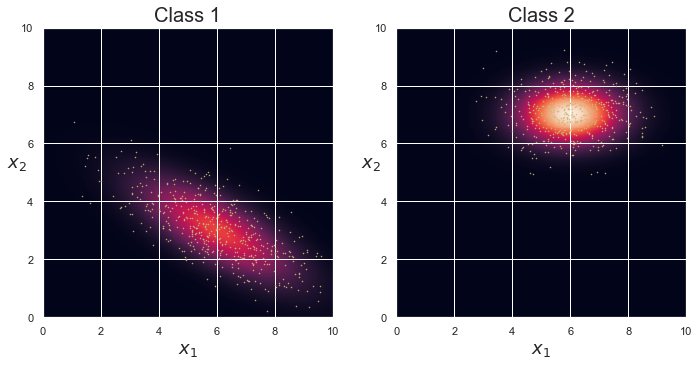

In [8]:
# Remove datapoints outside figure limits
X0_n = X0[(X0[:,0]>x_min) & (X0[:,0]<x_max) & (X0[:,1]>y_min) & (X0[:,1]<y_max)]
X1_n = X1[(X1[:,0]>x_min) & (X1[:,0]<x_max) & (X1[:,1]>y_min) & (X1[:,1]<y_max)]


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5), subplot_kw={'aspect': 'equal'})

ax1.imshow(pdf0, vmin=0, vmax=pdf_max, extent=[x_min, x_max, y_min, y_max])
ax1.scatter(X0_n[:, 0], X0_n[:, 1], c="y", s=1, marker=".")
ax1.set_ylabel('$x_{2}$',rotation=0, fontsize=18) 
ax1.set_xlabel('$x_{1}$', fontsize=18)
ax1.set_title('Class 1', fontsize=20)

ax2.imshow(pdf1, vmin=0, vmax=pdf_max, extent=[x_min, x_max, y_min, y_max])
ax2.scatter(X1_n[:, 0], X1_n[:, 1], c="y", s=1, marker=".")
ax2.set_ylabel('$x_{2}$',rotation=0, fontsize=18)  
ax2.set_xlabel('$x_{1}$', fontsize=18)
ax2.set_title('Class 2', fontsize=20)

fig.tight_layout()
plt.show()


Using this experimental data, we can estimate the parameters of each gaussian PDF. The more 
data points we have, the better the parameter estimations and the more precise the classification 
results.

In [9]:
# The hat notation is used to identify estimated parameters.
Mu_hat = np.zeros([2,2])
Mu_hat[0,:] = np.mean(X0,axis=0)
Mu_hat[1,:] = np.mean(X1,axis=0)

Sigma_hat = np.zeros([2,2,2])
Sigma_hat[:,:,0] = np.cov(X0.T)
Sigma_hat[:,:,1] = np.cov(X1.T)

pC_hat = prob_C            


## Quadratic Discriminant Analysis 
Now that we have parameter estimates for each PDF component, we can compute the discriminant functions $h_{i}(\bf{x})$ 
at every point on the spatial grid. They are defined as

<blockquote>  $h_{i}(\bf{x}) = \ln P(\bf{x}|C_{i}) P(C_{i}) =\frac{1}{2}\ln |\Sigma_{i}| -\frac{1}{2}(\bf{x}-\bf{\mu})^\top \Sigma^{-1} (\bf{x}-\bf{\mu}) + \ln P(C_{i})$  </blockquote>

up to an additive constant.

The zone of influence of each class is defined as:
<blockquote>  Class 1: $h_{1}(\bf{x}) > h_{2}(\bf{x})$ </blockquote>
<blockquote>  Class 2: $h_{2}(\bf{x}) > h_{1}(\bf{x})$ </blockquote>
    

In [10]:
X = np.c_[xx.ravel(), yy.ravel()]
h = np.zeros(X.shape)

X = X.T
Mu_hat = Mu_hat.T

# Compute the discriminant functions h for the gaussian PDF
for i in range(n_PDF):
    mu = Mu_hat[:,i]

    S_inv = np.linalg.inv(Sigma_hat[:,:,i])
    det_S = np.linalg.det(Sigma_hat[:,:,i])

    w0 = -0.5*math.log(det_S) + math.log(pC_hat[i])

    ww = np.zeros((X.shape[1],1))
    for j in range(X.shape[1]):
        dX = (X[:,j] - mu).reshape(-1, 1)
        ww[j] = (dX.T).dot(S_inv.dot(dX))

    h[:,i] = (-0.5*ww + w0).ravel()


# Find the influence zone of each class on the spatial grid. 
# Winning class
C = h[:,1]>h[:,0]

C = C.reshape(xx.shape)
C = C.astype(float)

mask = C


## Show the discriminant functions $h_{i}(\bf{x})$

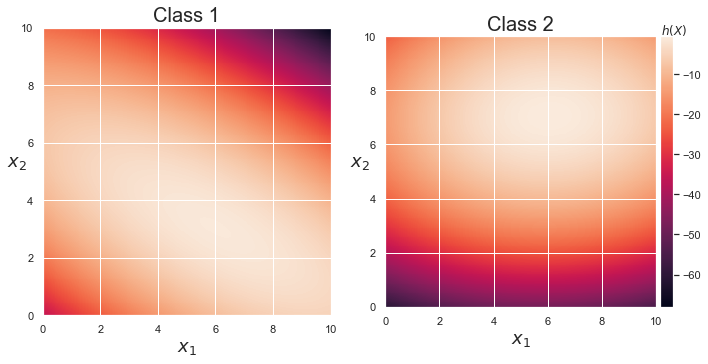

In [11]:
h0 = h[:,0].reshape(xx.shape)
h0 = np.flipud(h0)
h1 = h[:,1].reshape(xx.shape)
h1 = np.flipud(h1)

h_min = np.min([np.min(h0), np.min(h1)])
h_max = np.max([np.max(h0), np.max(h1)])


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5), subplot_kw={'aspect': 'equal'})

ax1.imshow(h0, vmin=h_min, vmax=h_max, extent=[x_min, x_max, y_min, y_max])
ax1.set_ylabel('$x_{2}$',rotation=0, fontsize=18) 
ax1.set_xlabel('$x_{1}$', fontsize=18)
ax1.set_title('Class 1', fontsize=20)

im = ax2.imshow(h1, vmin=h_min, vmax=h_max, extent=[x_min, x_max, y_min, y_max])
ax2.set_ylabel('$x_{2}$',rotation=0, fontsize=18)  
ax2.set_xlabel('$x_{1}$', fontsize=18)
ax2.set_title('Class 2', fontsize=20)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)

clb = plt.colorbar(im, cax=cax)
clb.set_label('$h(X)$', labelpad=-40, y=1.05, rotation=0, horizontalalignment='left')

fig.tight_layout()
plt.show()

# Display the boundary of the influence zone of each class
The underlying PDF is the TRUE one, i.e. the one that was used to generate the experimental data.

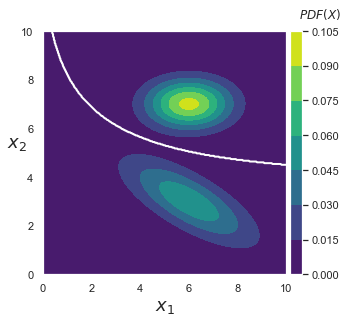

In [12]:
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'aspect': 'equal'})

ax.contour(xx, yy, C, [0.5], linewidths=2., colors='white') 
im = ax.contourf(xx, yy, pdf, cmap='viridis')

ax.set_ylabel('$x_{2}$',rotation=0, fontsize=18)  
ax.set_xlabel('$x_{1}$', fontsize=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

clb = plt.colorbar(im, cax=cax)
clb.set_label('$PDF(X)$', labelpad=-40, y=1.1, rotation=0, horizontalalignment='left')

fig.tight_layout()
plt.show()

## Show the global PDF in 3D with the influence zone of each class
The underlying PDF (in 2D and 3D) is the TRUE one, i.e. the one that was used to generate the experimental data.
N.B. There may be some slight mismatches between the overlying and underlying boundaries due to differences in resolution. 

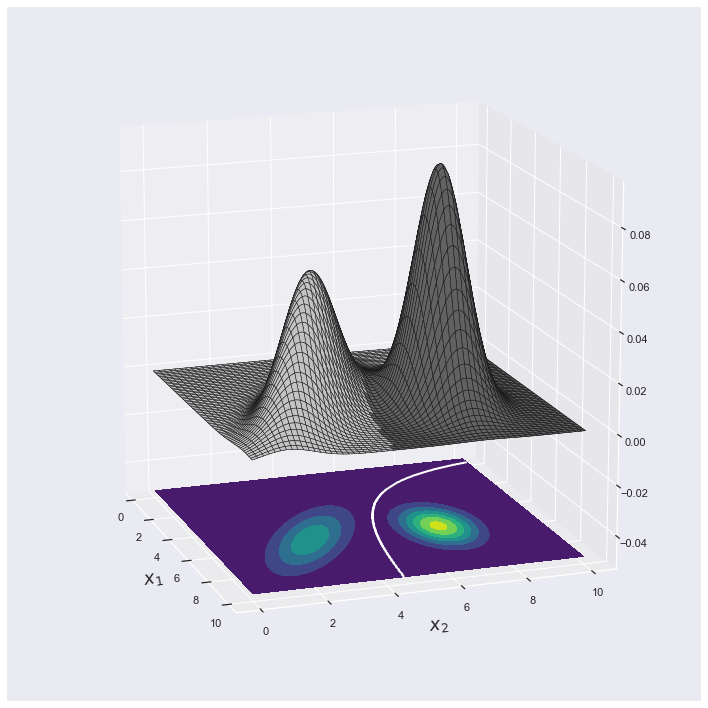

In [13]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')

# Generate OVERLYING 3-D surface with colors indicating the influence zone of each class
rstride, cstride = 5, 5
s = ax.plot_surface(xx, yy, pdf, rstride=rstride, cstride=cstride, linewidth=.5, antialiased=True, color='w', edgecolors='k')       
a1 = s.__dict__['_original_facecolor']
b1 = s.__dict__['_facecolors']
c1 = s.__dict__['_facecolors3d']

s = ax.plot_surface(xx, yy, pdf, rstride=rstride, cstride=cstride, linewidth=.5, antialiased=True, color='gray', edgecolors='k')
a2 = s.__dict__['_original_facecolor']
b2 = s.__dict__['_facecolors']
c2 = s.__dict__['_facecolors3d']

Lx = int(nx/rstride)
Ly = int(ny/cstride)

mask = resize(mask, (Lx,Ly), order=0)
indx = np.argwhere(mask)
idx = indx[:,0]*Lx + indx[:,1]

a = a1
b = b1
c = c1
for i in idx:
    a[i,:] = a2[i,:]
    b[i,:] = b2[i,:]
    c[i,:] = c2[i,:]
s.__dict__['_original_facecolor'] = a
s.__dict__['_facecolors'] = b
s.__dict__['_facecolors3d'] = c    


# Generate UNDERLYING contours with borders between each class
offset = -0.05
cset = ax.contourf(xx, yy, pdf, zdir='z', offset=offset, cmap='viridis')

# Display the boundary of the influence zone of each class
ax.contour(xx, yy, C, [0.5], offset=offset, linewidths=2., colors='white') 

ax.set_zlim(offset,np.max(pdf))

view=[15.6, -19]
ax.view_init(view[0], view[1])

ax.set_ylabel('$x_{2}$', fontsize=18)
ax.xaxis.set_rotate_label(False)  
ax.set_xlabel('$x_{1}$', rotation=10, fontsize=18)

fig.tight_layout()


plt.savefig("Classification_example_of_quadratic_discriminant_1.png", format="png")        

plt.show()


# Part II:   Various examples of gaussian mixtures with classification results. 
The following function contains most of the code in the previous cells; we use it to
display the classification results for each example.

In [14]:
def generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, npts, figName, z_offset=-0.1, view=[15, -20]):
    
    #---------- Generate TRUE gaussian probability data distributions (PDF) ----------
    
    # Compute the covariance matrix Sigma for each gaussian PDF
    n_PDF = 2
    Sigma = np.zeros((2, 2, n_PDF))
    for n in range(n_PDF):
        cov = np.zeros((2, 2))

        # Rotation matrix
        angle = np.radians(theta[n])
        c, s = np.cos(angle), np.sin(angle)
        R = np.array([[c, -s], [s, c]])

        # Covariance matrix for a PDF with its principal axes oriented along the x and y directions
        C = np.array([[sigma[n,0]**2, 0.],[0., sigma[n,1]**2]])

        # Covariance matrix after rotation
        Sigma[:,:,n] = R.dot(C.dot(R.T))


    # Generate a spatial grid where the PDF will be evaluated locally.
    nx, ny = 300, 300
    xx, yy = np.meshgrid(np.linspace(0., 10., nx), np.linspace(0., 10., ny))
    pos = np.dstack((xx, yy)) 
    

    # Compute the global PDF as a sum of weighted PDF
    pdf = 0
    for n in range(n_PDF):
        model = multivariate_normal(Mu[n,:], Sigma[:,:,n]) 
        pdf +=prob_C[n]*model.pdf(pos)

        
    #------------- Generate datasets based on the estimated parameters of the TRUE distributions --------
    
    # Number of data points allocated to each PDF 
    n = (npts*prob_C).astype(int)

    X0 = np.random.multivariate_normal(Mu[0], Sigma[:,:,0], n[0])        
    X1 = np.random.multivariate_normal(Mu[1], Sigma[:,:,1], n[1])
    X = np.r_[X0, X1]
    y = np.hstack((np.zeros(n[0]), np.ones(n[1])))
    
    # Evaluate the gaussian PDF parameters based on the available data, i.e. the new dataset. 
    Mu_hat = np.zeros([2,2])
    Mu_hat[0,:] = np.mean(X0,axis=0)
    Mu_hat[1,:] = np.mean(X1,axis=0)

    Sigma_hat = np.zeros([2,2,2])
    Sigma_hat[:,:,0] = np.cov(X0.T)
    Sigma_hat[:,:,1] = np.cov(X1.T)

    pC_hat = prob_C

    
    # ------------- Classification ------------------------
    
    # Generate a classification at every point on the spatial grid based on the available data
    X = np.c_[xx.ravel(), yy.ravel()]
    h = np.zeros(X.shape)

    X = X.T
    Mu_hat = Mu_hat.T

    # Define the discriminant functions h for the gaussian PDF
    for i in range(n_PDF):
        mu = Mu_hat[:,i]

        S_inv = np.linalg.inv(Sigma_hat[:,:,i])
        det_S = np.linalg.det(Sigma_hat[:,:,i])

        w0 = -0.5*math.log(det_S) + math.log(pC_hat[i])

        ww = np.zeros((X.shape[1],1))
        for j in range(X.shape[1]):
            dX = (X[:,j] - mu).reshape(-1, 1)
            ww[j] = (dX.T).dot(S_inv.dot(dX))

        h[:,i] = (-0.5*ww + w0).ravel()


    # Find the winning class and its influence zone on the spatial grid. 
    C = h[:,1]>h[:,0]

    C = C.reshape(xx.shape)
    mask = C

    # -------------- Display the results ------------------------
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.gca(projection='3d')

    # Generate OVERLYING 3-D surface with colors indicating the influence zone of each class
    rstride, cstride = 5, 5
    s = ax.plot_surface(xx, yy, pdf, rstride=rstride, cstride=cstride, linewidth=.5, antialiased=True, color='w', edgecolors='k')       
    a1 = s.__dict__['_original_facecolor']
    b1 = s.__dict__['_facecolors']
    c1 = s.__dict__['_facecolors3d']

    s = ax.plot_surface(xx, yy, pdf, rstride=rstride, cstride=cstride, linewidth=.5, antialiased=True, color='gray', edgecolors='k')
    a2 = s.__dict__['_original_facecolor']
    b2 = s.__dict__['_facecolors']
    c2 = s.__dict__['_facecolors3d']

    Lx = int(nx/rstride)
    Ly = int(ny/cstride)

    mask = resize(mask, (Lx,Ly), order=0)
    indx = np.argwhere(mask)
    idx = indx[:,0]*Lx + indx[:,1]

    a = a1
    b = b1
    c = c1
    for i in idx:
        a[i,:] = a2[i,:]
        b[i,:] = b2[i,:]
        c[i,:] = c2[i,:]
    s.__dict__['_original_facecolor'] = a
    s.__dict__['_facecolors'] = b
    s.__dict__['_facecolors3d'] = c    


    # Generate UNDERLYING contours with borders between each class
    cset = ax.contourf(xx, yy, pdf, zdir='z', offset=z_offset, cmap='viridis')

    # Display the boundary of the influence zone of each class
    ax.contour(xx, yy, C, [0.5], offset=z_offset, linewidths=2., colors='white') 

    ax.set_zlim(z_offset,np.max(pdf))

    ax.view_init(view[0], view[1])

    ax.set_ylabel('$x_{2}$', fontsize=18)
    ax.xaxis.set_rotate_label(False)  
    ax.set_xlabel('$x_{1}$', rotation=10, fontsize=18)

    fig.tight_layout()

    plt.savefig(figName, format="png")        

    plt.show()
    
    

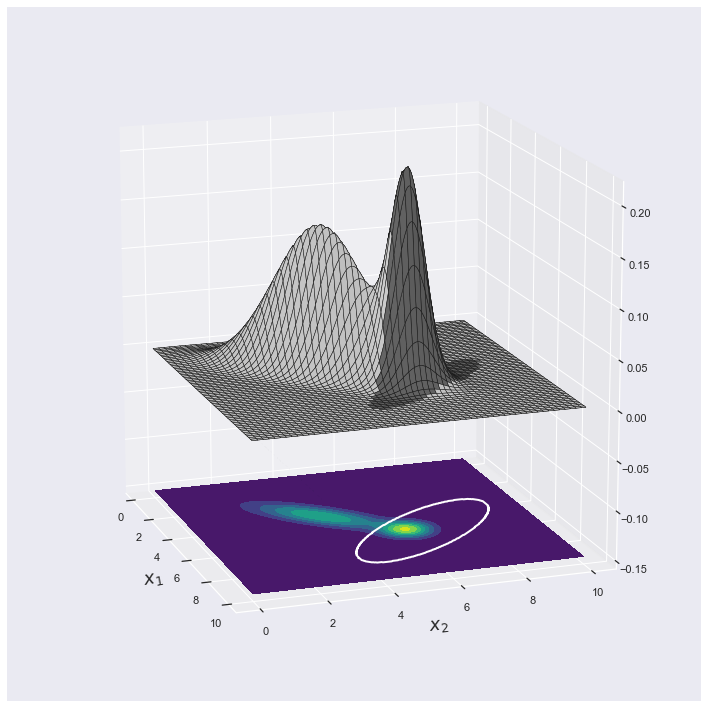

In [15]:
# For replicability
np.random.seed(42)


# Parameters of the two gaussians PDF
Mu = np.zeros((2,2))
Mu[0,:] = [4., 4.]
Mu[1,:] = [6., 6.]

sigma = np.zeros((2,2))
sigma[0,:] = [1.5, .5]
sigma[1,:] = [0.5, 0.5]

theta = np.array([45., 0.]) 

prob_C = np.array([0.7, 0.3]) 

npts = 1000

z_offset = -0.15

view=[15.6, -19]
figName = "Classification_example_of_quadratic_discriminant_2.png"

generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, npts, figName, z_offset, view)
    

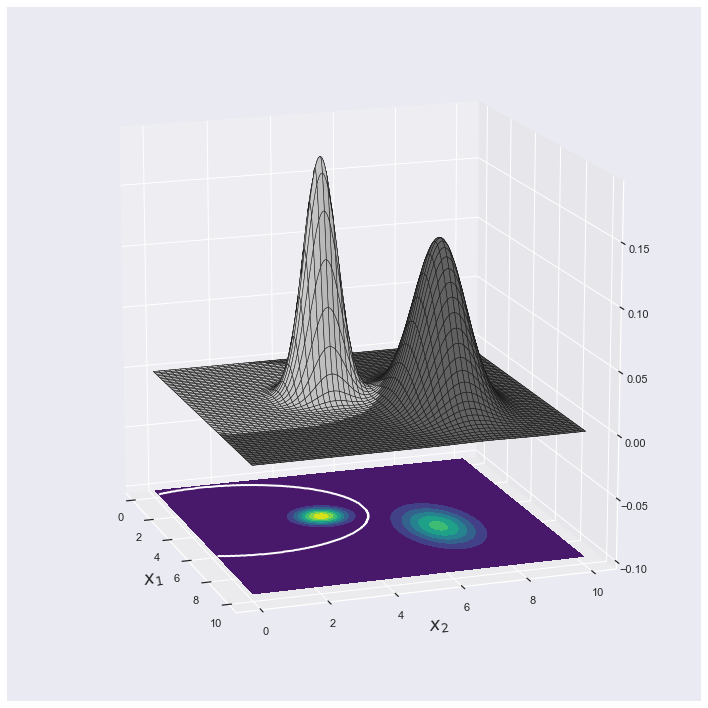

In [16]:
# For replicability
np.random.seed(42)

# Parameters of the two gaussians PDF
Mu = np.zeros((2,2))
Mu[0,:] = [4., 4.]
Mu[1,:] = [6., 7.]

sigma = np.zeros((2,2))
sigma[0,:] = [0.5, 0.5]
sigma[1,:] = [1.2, 0.7]

theta = np.array([-30., 0.])  

prob_C = np.array([0.3, 0.7]) 

    
npts = 1000

z_offset = -0.1

view=[15.6, -19]

figName = "Classification_example_of_quadratic_discriminant_3.png"

generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, npts, figName, z_offset, view) 
    

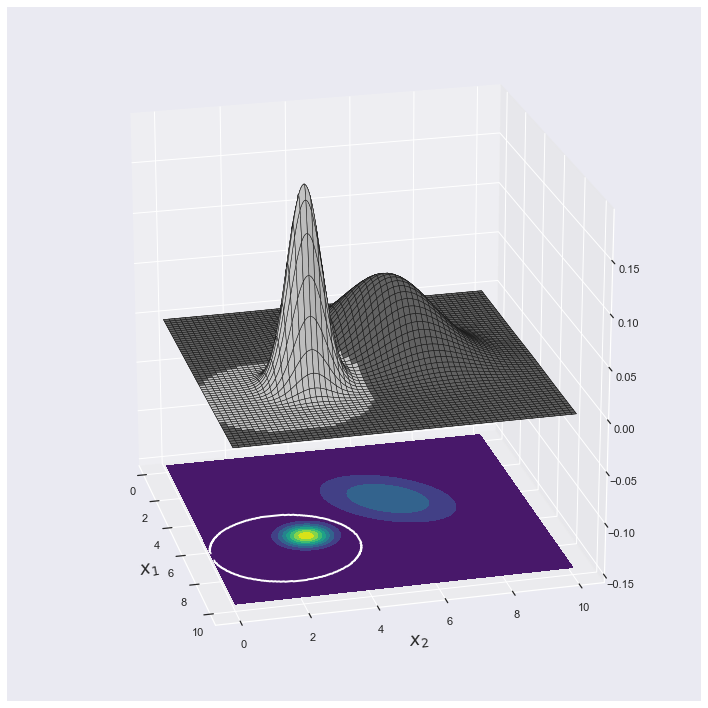

In [17]:
# For replicability
np.random.seed(42)

# Parameters of the two gaussians PDF
Mu = np.zeros((2,2))
Mu[0,:] = [6., 3.]
Mu[1,:] = [4., 6.]

sigma = np.zeros((2,2))
sigma[0,:] = [.5, .5]
sigma[1,:] = [1., 1.5]

theta = np.array([0., -45.]) 
prob_C = np.array([0.3, 0.7]) 

npts = 1000

z_offset = -0.15

view = [22., -14]

figName = "Classification_example_of_quadratic_discriminant_4.png"

generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, npts, figName, z_offset, view)  
   

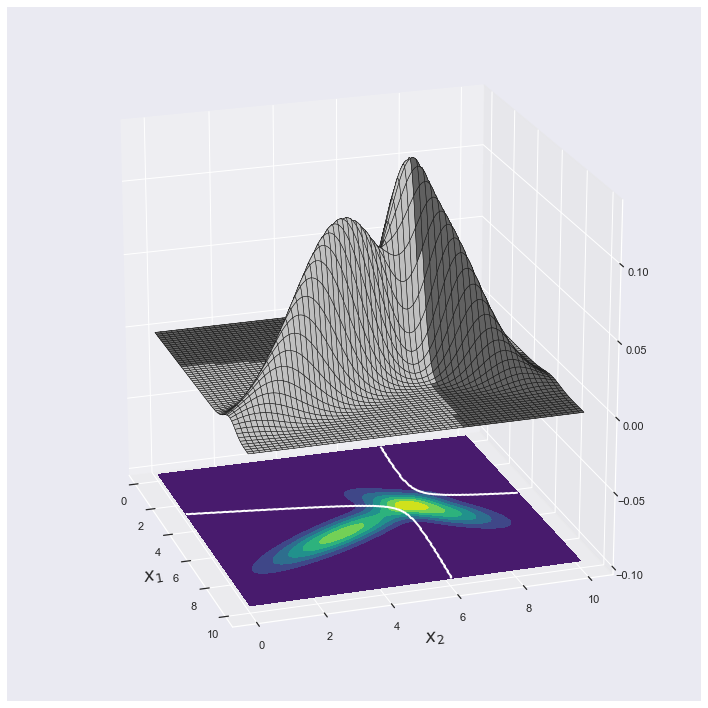

In [18]:
# For replicability
np.random.seed(42)

# Parameters of the two gaussians PDF
Mu = np.zeros((2,2))
Mu[0,:] = [6., 4.]
Mu[1,:] = [5., 7.]

sigma = np.zeros((2,2))
sigma[0,:] = [2., 0.5]
sigma[1,:] = [1.5, 0.5]

theta = np.array([-60., 45.]) 
prob_C = np.array([0.7, 0.5]) 

npts = 1000

z_offset = -0.1

view = [21., -18]

figName = "Classification_example_of_quadratic_discriminant_5.png"

generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, npts, figName, z_offset, view)  

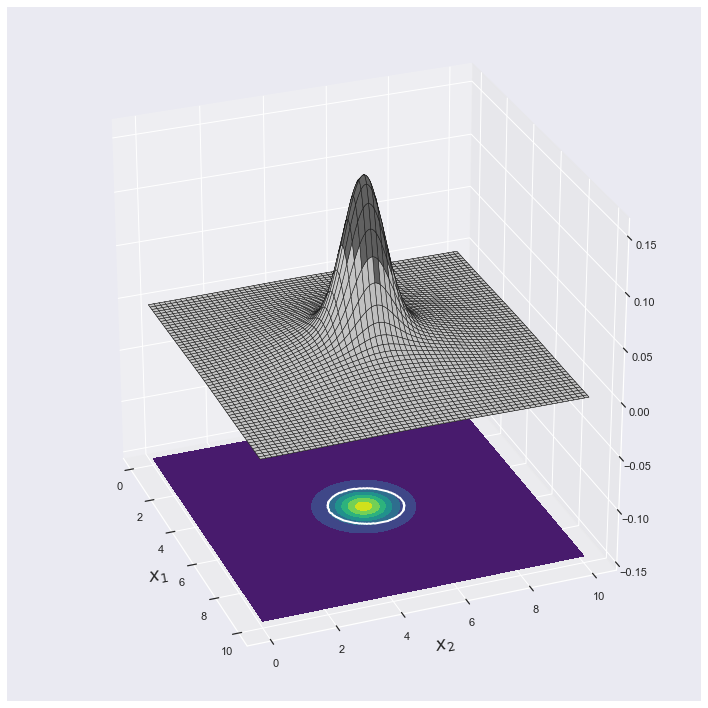

In [19]:
# For replicability
np.random.seed(42)

# Parameters of the two gaussians PDF
Mu = np.zeros((2,2))
Mu[0,:] = [5., 5.]
Mu[1,:] = [5., 5.]

sigma = np.zeros((2,2))
sigma[0,:] = [2, 2]
sigma[1,:] = [0.6, 0.6]

theta = np.array([0., 0.]) 
prob_C = np.array([0.7, 0.3]) 

npts = 1000

z_offset = -0.15

view = [28., -21]

figName = "Classification_example_of_quadratic_discriminant_6.png"

generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, npts, figName, z_offset, view)